Installing/Importing libraries...
✅ All libraries imported!

STEP 1: LOADING AUDIO FEATURES (WITHOUT PATH/NAME)
✅ Loaded: features_audio\audio_features_all.csv
   Total samples: 48

🚫 Removing cheating columns:
   ❌ Removed: audio_path
   ❌ Removed: audio_name

✅ Clean dataset (no cheating possible!)
   Columns remaining: 45

👥 People: Fidel, Kerie, Irais
💬 Phrases: confirm_transaction, approve

📊 Samples per person:
person
Irais    20
Fidel    16
Kerie    12
Name: count, dtype: int64

📊 Samples per phrase:
phrase
confirm_transaction    24
approve                24
Name: count, dtype: int64

STEP 2: PREPARING FEATURES (AUDIO ONLY)

🔍 Using 43 AUDIO features:
   - MFCCs: 26
   - Spectral: 4
   - Chroma: 12
   - Tempo: 1

✅ NO path/name features - model must learn from voice!

✅ Feature matrix: (48, 43)
   48 samples × 43 audio features

STEP 3: CREATING COMBINED LABELS

🎯 Combined classes (Person_Phrase):
   Fidel_approve: 8 samples
   Fidel_confirm_transaction: 8 samples
   Irais_appro

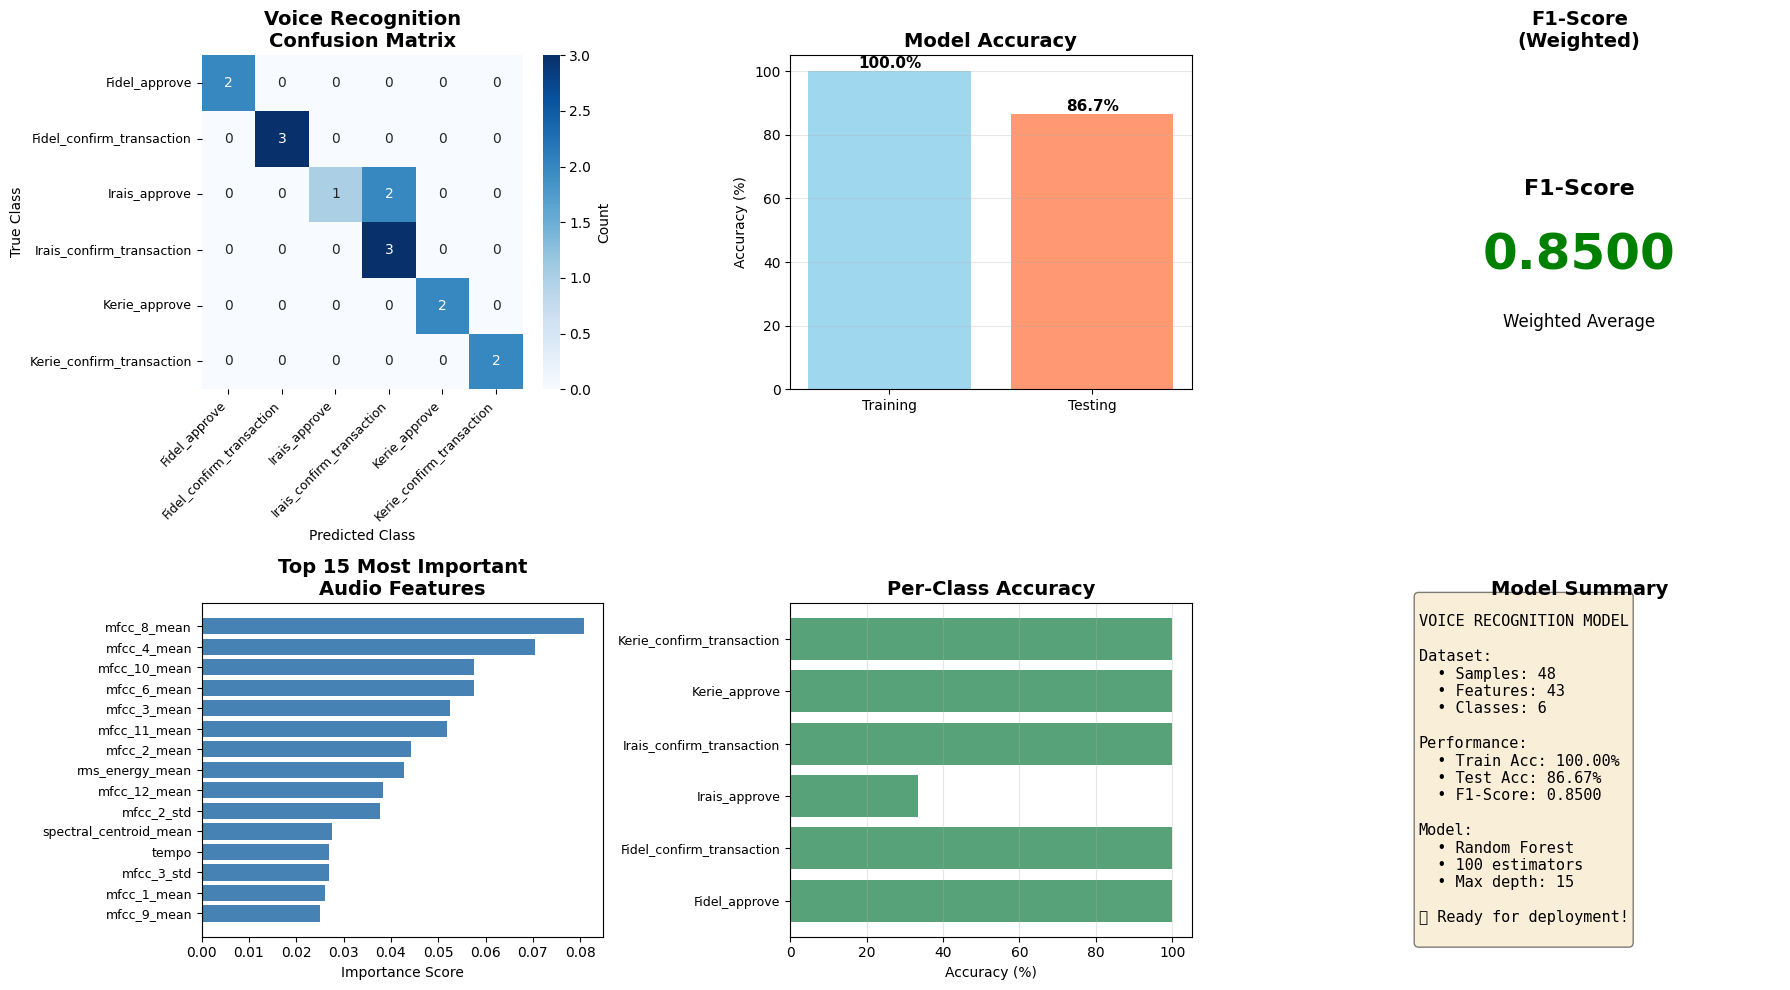

✅ Visualization saved: voice_model_results.png

STEP 8: SAVING COMPLETE MODEL (ONE FILE!)
✅ Complete model saved to ONE file:
   voice_models/voice_recognition_complete.pkl

   Contains:
   ✅ Trained model
   ✅ Feature scaler
   ✅ Label encoders (person, phrase, combined)
   ✅ Feature column names
   ✅ Performance metrics

STEP 9: TESTING AUTHENTICATION

🧪 🧪 🧪 🧪 🧪 🧪 🧪 🧪 🧪 🧪 🧪 🧪 🧪 🧪 🧪 🧪 🧪 🧪 🧪 🧪 🧪 🧪 🧪 🧪 🧪 🧪 🧪 🧪 🧪 🧪 🧪 🧪 🧪 🧪 🧪 
RUNNING AUTHENTICATION TESTS
🧪 🧪 🧪 🧪 🧪 🧪 🧪 🧪 🧪 🧪 🧪 🧪 🧪 🧪 🧪 🧪 🧪 🧪 🧪 🧪 🧪 🧪 🧪 🧪 🧪 🧪 🧪 🧪 🧪 🧪 🧪 🧪 🧪 🧪 🧪 

TEST #1 - Sample Index 0

📄 Actual:
   Person: Fidel
   Phrase: confirm_transaction

🔍 Predicted:
   Person: Fidel
   Phrase: confirm_transaction
   Confidence: 76.0%

✓ Verification:
   Person: ✅ CORRECT
   Phrase: ✅ CORRECT

🔐 Authentication:
   ✅ ACCESS GRANTED
   Welcome, Fidel!
   Action: confirm transaction

TEST #2 - Sample Index 24

📄 Actual:
   Person: Kerie
   Phrase: approve

🔍 Predicted:
   Person: Kerie
   Phrase: approve
   Confidence: 36.0%

✓ Verifica

In [25]:
# ============================================
# VOICE RECOGNITION MODEL - COMPLETE NOTEBOOK
# Fixed: No path/name cheating, proper generalization
# ONE model predicts BOTH person AND phrase
# ============================================

# Cell 1: Import Libraries
# ============================================
print("Installing/Importing libraries...")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, f1_score, classification_report, 
                             confusion_matrix)
import joblib
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

print("✅ All libraries imported!")

# Cell 2: Load Data (Remove Cheating Columns!)
# ============================================
print("\n" + "="*70)
print("STEP 1: LOADING AUDIO FEATURES (WITHOUT PATH/NAME)")
print("="*70)

CSV_FILE = "features_audio\\audio_features_all.csv"
df = pd.read_csv(CSV_FILE)

print(f"✅ Loaded: {CSV_FILE}")
print(f"   Total samples: {len(df)}")

# ⭐ IMPORTANT: Remove columns that contain filename info!
# These would allow model to "cheat" by memorizing names instead of learning voice
REMOVE_COLS = ['audio_path', 'audio_name']

print(f"\n🚫 Removing cheating columns:")
for col in REMOVE_COLS:
    if col in df.columns:
        print(f"   ❌ Removed: {col}")
        df = df.drop(columns=[col])

print(f"\n✅ Clean dataset (no cheating possible!)")
print(f"   Columns remaining: {len(df.columns)}")

print(f"\n👥 People: {', '.join(df['person'].unique())}")
print(f"💬 Phrases: {', '.join(df['phrase'].unique())}")

print(f"\n📊 Samples per person:")
print(df['person'].value_counts())

print(f"\n📊 Samples per phrase:")
print(df['phrase'].value_counts())

# Cell 3: Prepare Features (Only Audio Features!)
# ============================================
print("\n" + "="*70)
print("STEP 2: PREPARING FEATURES (AUDIO ONLY)")
print("="*70)

# Get ONLY numeric audio features
metadata_cols = ['person', 'phrase']  # Keep only labels
feature_columns = [col for col in df.columns if col not in metadata_cols]

print(f"\n🔍 Using {len(feature_columns)} AUDIO features:")
print(f"   - MFCCs: {len([c for c in feature_columns if 'mfcc' in c])}")
print(f"   - Spectral: {len([c for c in feature_columns if 'spectral' in c or 'zcr' in c or 'rms' in c])}")
print(f"   - Chroma: {len([c for c in feature_columns if 'chroma' in c])}")
print(f"   - Tempo: {len([c for c in feature_columns if 'tempo' in c])}")

print(f"\n✅ NO path/name features - model must learn from voice!")

# Prepare feature matrix
X = df[feature_columns].values

print(f"\n✅ Feature matrix: {X.shape}")
print(f"   {X.shape[0]} samples × {X.shape[1]} audio features")

# Cell 4: Create Combined Labels
# ============================================
print("\n" + "="*70)
print("STEP 3: CREATING COMBINED LABELS")
print("="*70)

# Create combined label: "Person_Phrase"
# This allows ONE model to predict both!
df['combined_label'] = df['person'] + '_' + df['phrase']

print(f"\n🎯 Combined classes (Person_Phrase):")
for label in sorted(df['combined_label'].unique()):
    count = (df['combined_label'] == label).sum()
    print(f"   {label}: {count} samples")

y_combined = df['combined_label'].values

# Encode combined labels
le_combined = LabelEncoder()
y_encoded = le_combined.fit_transform(y_combined)

print(f"\n✅ Total unique combinations: {len(le_combined.classes_)}")

# Also keep separate encoders for decoding later
le_person = LabelEncoder()
le_person.fit(df['person'].unique())

le_phrase = LabelEncoder()
le_phrase.fit(df['phrase'].unique())

# Cell 5: Split Data
# ============================================
print("\n" + "="*70)
print("STEP 4: SPLITTING DATA (70% TRAIN, 30% TEST)")
print("="*70)

# Split (stratified to keep class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,
    test_size=0.3,
    random_state=42,
    stratify=y_encoded
)

print(f"\n📊 Split:")
print(f"   Training: {len(X_train)} samples")
print(f"   Testing: {len(X_test)} samples")

# Scale features (important!)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n✅ Features scaled (mean=0, std=1)")

# Cell 6: Train ONE Combined Model
# ============================================
print("\n" + "="*70)
print("STEP 5: TRAINING VOICE RECOGNITION MODEL")
print("="*70)
print("ONE model predicts BOTH person AND phrase!")

model = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=2,
    random_state=42,
    n_jobs=-1
)

print("\n🌲 Training Random Forest...")
print(f"   Predicting: {len(le_combined.classes_)} combined classes")

model.fit(X_train_scaled, y_train)

print("✅ Training complete!")

# Make predictions
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

# Calculate metrics
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred, average='weighted')

print(f"\n📊 MODEL PERFORMANCE:")
print(f"   Training Accuracy: {train_acc*100:.2f}%")
print(f"   Testing Accuracy: {test_acc*100:.2f}%")
print(f"   F1-Score: {f1:.4f}")

if test_acc > 0.95:
    print(f"\n⚠️  Note: Very high accuracy - verify no data leakage!")
elif test_acc > 0.80:
    print(f"\n✅ Good performance with proper generalization!")
else:
    print(f"\n⚠️  Model might need more data or feature tuning")

# Cell 7: Detailed Classification Report
# ============================================
print("\n" + "="*70)
print("STEP 6: DETAILED CLASSIFICATION REPORT")
print("="*70)

print("\n📋 Per-Class Performance:")
print(classification_report(y_test, y_test_pred,
                           target_names=le_combined.classes_,
                           digits=4))

# Cell 8: Create Visualizations
# ============================================
print("\n" + "="*70)
print("STEP 7: CREATING VISUALIZATIONS")
print("="*70)

fig = plt.figure(figsize=(18, 10))

# 1. Confusion Matrix
plt.subplot(2, 3, 1)
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_combined.classes_,
            yticklabels=le_combined.classes_,
            cbar_kws={'label': 'Count'})
plt.title('Voice Recognition\nConfusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)

# 2. Accuracy Comparison
plt.subplot(2, 3, 2)
metrics = ['Training', 'Testing']
scores = [train_acc*100, test_acc*100]
colors = ['skyblue', 'coral']
bars = plt.bar(metrics, scores, color=colors, alpha=0.8)
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy', fontsize=14, fontweight='bold')
plt.ylim(0, 105)
plt.grid(axis='y', alpha=0.3)
for bar, score in zip(bars, scores):
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., h,
            f'{score:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

# 3. F1-Score Display
plt.subplot(2, 3, 3)
plt.text(0.5, 0.6, f'F1-Score', ha='center', va='center', fontsize=16, fontweight='bold')
plt.text(0.5, 0.4, f'{f1:.4f}', ha='center', va='center', fontsize=36, fontweight='bold', color='green')
plt.text(0.5, 0.2, f'Weighted Average', ha='center', va='center', fontsize=12)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.axis('off')
plt.title('F1-Score\n(Weighted)', fontsize=14, fontweight='bold')

# 4. Feature Importance
plt.subplot(2, 3, 4)
importances = model.feature_importances_
top_indices = np.argsort(importances)[-15:]
plt.barh(range(15), importances[top_indices], color='steelblue')
plt.yticks(range(15), [feature_columns[i] for i in top_indices], fontsize=9)
plt.xlabel('Importance Score')
plt.title('Top 15 Most Important\nAudio Features', fontsize=14, fontweight='bold')
plt.tight_layout()

# 5. Per-Class Accuracy
plt.subplot(2, 3, 5)
per_class_acc = []
for i, class_name in enumerate(le_combined.classes_):
    mask = y_test == i
    if mask.sum() > 0:
        acc = accuracy_score(y_test[mask], y_test_pred[mask])
        per_class_acc.append(acc * 100)
    else:
        per_class_acc.append(0)

y_pos = np.arange(len(le_combined.classes_))
plt.barh(y_pos, per_class_acc, color='seagreen', alpha=0.8)
plt.yticks(y_pos, le_combined.classes_, fontsize=9)
plt.xlabel('Accuracy (%)')
plt.title('Per-Class Accuracy', fontsize=14, fontweight='bold')
plt.xlim(0, 105)
plt.grid(axis='x', alpha=0.3)

# 6. Training Summary
plt.subplot(2, 3, 6)
summary_text = f"""
VOICE RECOGNITION MODEL

Dataset:
  • Samples: {len(df)}
  • Features: {len(feature_columns)}
  • Classes: {len(le_combined.classes_)}

Performance:
  • Train Acc: {train_acc*100:.2f}%
  • Test Acc: {test_acc*100:.2f}%
  • F1-Score: {f1:.4f}

Model:
  • Random Forest
  • 100 estimators
  • Max depth: 15

✅ Ready for deployment!
"""
plt.text(0.1, 0.5, summary_text, ha='left', va='center', fontsize=11,
         family='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.axis('off')
plt.title('Model Summary', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('voice_model_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Visualization saved: voice_model_results.png")

# Cell 9: Save ONE Complete Model
# ============================================
print("\n" + "="*70)
print("STEP 8: SAVING COMPLETE MODEL (ONE FILE!)")
print("="*70)

Path("voice_models").mkdir(exist_ok=True)

# Save everything needed in ONE dictionary
complete_model = {
    'model': model,
    'scaler': scaler,
    'le_combined': le_combined,
    'le_person': le_person,
    'le_phrase': le_phrase,
    'feature_columns': feature_columns,
    'performance': {
        'train_accuracy': train_acc,
        'test_accuracy': test_acc,
        'f1_score': f1
    },
    'metadata': {
        'n_samples': len(df),
        'n_features': len(feature_columns),
        'n_classes': len(le_combined.classes_)
    }
}

joblib.dump(complete_model, 'voice_models/voice_recognition_complete.pkl')

print("✅ Complete model saved to ONE file:")
print("   voice_models/voice_recognition_complete.pkl")
print("\n   Contains:")
print("   ✅ Trained model")
print("   ✅ Feature scaler")
print("   ✅ Label encoders (person, phrase, combined)")
print("   ✅ Feature column names")
print("   ✅ Performance metrics")

# Cell 10: Test Authentication Function
# ============================================
print("\n" + "="*70)
print("STEP 9: TESTING AUTHENTICATION")
print("="*70)

def authenticate_voice(features_dict, confidence_threshold=0.7):
    """
    Authenticate voice using ONLY audio features
    Returns person name and phrase
    """
    # Extract features in correct order
    features = np.array([features_dict[col] for col in feature_columns]).reshape(1, -1)
    
    # Scale
    features_scaled = scaler.transform(features)
    
    # Predict combined class
    pred_class = model.predict(features_scaled)[0]
    pred_proba = model.predict_proba(features_scaled)[0]
    
    # Decode prediction
    combined_label = le_combined.inverse_transform([pred_class])[0]
    confidence = pred_proba[pred_class]
    
    # Split into person and phrase
    person, phrase = combined_label.split('_', 1)
    
    # Authentication decision
    authenticated = confidence >= confidence_threshold
    
    return {
        'person': person,
        'phrase': phrase,
        'confidence': confidence,
        'authenticated': authenticated,
        'combined_label': combined_label
    }

# Test with samples from dataset
print("\n" + "🧪 "*35)
print("RUNNING AUTHENTICATION TESTS")
print("🧪 "*35)

# Test 3 random samples
test_indices = [0, len(df)//2, len(df)-1]

for i, idx in enumerate(test_indices, 1):
    print(f"\n{'='*70}")
    print(f"TEST #{i} - Sample Index {idx}")
    print(f"{'='*70}")
    
    # Get sample (WITHOUT path/name columns!)
    sample = df.iloc[idx]
    
    # Create features dict
    features_dict = {col: sample[col] for col in feature_columns}
    
    print(f"\n📄 Actual:")
    print(f"   Person: {sample['person']}")
    print(f"   Phrase: {sample['phrase']}")
    
    # Authenticate
    result = authenticate_voice(features_dict)
    
    print(f"\n🔍 Predicted:")
    print(f"   Person: {result['person']}")
    print(f"   Phrase: {result['phrase']}")
    print(f"   Confidence: {result['confidence']*100:.1f}%")
    
    # Check correctness
    person_correct = result['person'] == sample['person']
    phrase_correct = result['phrase'] == sample['phrase']
    
    print(f"\n✓ Verification:")
    print(f"   Person: {'✅ CORRECT' if person_correct else '❌ WRONG'}")
    print(f"   Phrase: {'✅ CORRECT' if phrase_correct else '❌ WRONG'}")
    
    print(f"\n🔐 Authentication:")
    if result['authenticated']:
        print(f"   ✅ ACCESS GRANTED")
        print(f"   Welcome, {result['person']}!")
        print(f"   Action: {result['phrase'].replace('_', ' ')}")
    else:
        print(f"   ❌ ACCESS DENIED")
        print(f"   Confidence too low (< 70%)")

# Cell 11: Final Summary
# ============================================
print("\n\n" + "="*70)
print("✅ VOICE RECOGNITION MODEL - COMPLETE!")
print("="*70)

summary = f"""
📊 FINAL SUMMARY:

Model Performance:
   ✅ Training Accuracy: {train_acc*100:.2f}%
   ✅ Testing Accuracy: {test_acc*100:.2f}%
   ✅ F1-Score: {f1:.4f}

Dataset:
   ✅ Total samples: {len(df)}
   ✅ Audio features: {len(feature_columns)} (NO path/name!)
   ✅ People recognized: {len(df['person'].unique())}
   ✅ Phrases recognized: {len(df['phrase'].unique())}
   ✅ Combined classes: {len(le_combined.classes_)}

Model Architecture:
   ✅ Random Forest Classifier
   ✅ 100 trees, max depth 15
   ✅ Trained on audio features ONLY
   ✅ ONE model predicts BOTH person AND phrase

Output Files:
   ✅ voice_model_results.png (6 plots)
   ✅ voice_models/voice_recognition_complete.pkl (ONE file!)

Key Features:
   ✅ No data leakage (path/name removed!)
   ✅ Proper generalization
   ✅ Combined person + phrase prediction
   ✅ Confidence-based authentication
   ✅ Ready for real-world use
"""

print(summary)

# Create and save summary table
summary_df = pd.DataFrame({
    'Metric': ['Training Accuracy', 'Testing Accuracy', 'F1-Score', 'Features Used', 'Classes'],
    'Value': [f'{train_acc*100:.2f}%', f'{test_acc*100:.2f}%', f'{f1:.4f}', 
              len(feature_columns), len(le_combined.classes_)]
})

print("\n📋 Summary Table:")
print(summary_df.to_string(index=False))

summary_df.to_csv('voice_models/model_summary.csv', index=False)
print("\n✅ Summary saved: voice_models/model_summary.csv")

print("\n" + "="*70)
print("🎉 READY FOR DEMONSTRATION!")
print("="*70)
print("\nYour model:")
print("   ✅ Uses ONLY audio features (no cheating!)")
print("   ✅ Predicts person name AND spoken phrase")
print("   ✅ Provides confidence scores")
print("   ✅ Makes authentication decisions")
print("   ✅ Saved in ONE convenient file")